# 🖼️ Modern Image Classification Architectures
Welcome to the Computer Vision section of our repository! We're kicking things off with Image Classification, the "Hello, World!" of CV. The task is simple: given an image, assign it a single label (e.g., "cat," "dog," "car").

This task has driven decades of research, leading to powerful architectures. We'll explore two of the most influential:

**ResNet (Residual Networks)**: The architecture that finally allowed us to train extremely deep networks (100+ layers) by solving the "vanishing gradient" problem.

**EfficientNet**: A modern architecture designed not just for accuracy, but for computational efficiency. It answers the question: "What's the best way to 'scale up' a model for better performance?"

Let's dive in!

## 1. Setup: Installing Libraries

We'll be using `torchvision` for ResNet and the popular `timm` (PyTorch Image Models) library, which is the standard for accessing hundreds of pre-trained models, including EfficientNet.

In [1]:
!pip install -q timm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import timm # PyTorch Image Models

from PIL import Image
import requests
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. A Quick Primer: The Problem with "Going Deeper"
Before ResNet, the community believed "deeper is better." Models like AlexNet (8 layers) and VGG (19 layers) showed that adding more convolutional layers improved performance.

But a strange problem occurred: when people tried to train even deeper "plain" networks (e.g., 30+ layers), their performance got worse.

This wasn't overfitting! The 56-layer network performed worse on the training data than the 20-layer network. The problem was **vanishing gradients**. As the gradient flowed backward through so many layers, it multiplied by small numbers over and over, effectively shrinking to zero. The network's early layers simply couldn't learn.

## 3. ResNet: Conquering Depth with Residuals

ResNet (Residual Network) introduced a simple, brilliant idea in 2015 that solved this problem and allowed for networks of 100, 150, or even 1000 layers.

### The Solution: The "Skip Connection"

The core idea is the **residual block**. Instead of forcing a stack of layers to learn a transformation `H(x)` directly, ResNet has them learn a *residual function* `F(x)`.

The output is then: **`H(x) = F(x) + x`**



This `+ x` is the "skip connection" (or identity shortcut).

**Why does this work?**
1.  **Gradient Flow:** The `+ x` path acts as a "gradient highway." It allows the gradient to flow backward directly to earlier layers *without* being diminished by the layers in `F(x)`. This solves the vanishing gradient problem.
2.  **Easy Identity:** If a layer isn't useful, the network can easily learn to make `F(x) = 0`. The block then just becomes an *identity mapping* (`H(x) = x`), effectively "skipping" the layer. This means adding more layers can't *hurt* performance, it can only help or stay the same.

### Practical Example: Using a Pre-trained ResNet-50

Let's use a `ResNet-50` (50 layers) from `torchvision` to classify an image.

In [2]:
# 1. Load the pre-trained ResNet-50 model
# 'pretrained=True' was deprecated in favor of 'weights'
model_resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model_resnet50.eval() # Set to evaluation mode (important!)
model_resnet50.to(device)

print("ResNet-50 model loaded.")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


ResNet-50 model loaded.


### 3.1. Get Image and Preprocess
All pre-trained models expect images to be preprocessed in a specific way:

Resized to a fixed size (e.g., 224x224).

Converted to a PyTorch Tensor.

**Normalized** with a specific mean and standard deviation (the ones used during training on ImageNet).

ResNet transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


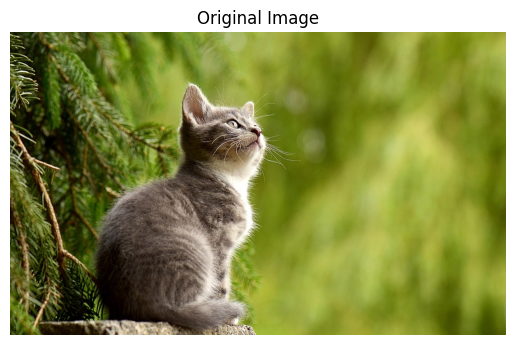

In [6]:
import io
# 2. Get the specific transforms for this model
# We can get them directly from the weights object
resnet_transforms = models.ResNet50_Weights.DEFAULT.transforms()
print(f"ResNet transforms:\n{resnet_transforms}")

# 3. Load a sample image
img_url = "https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_960_720.jpg"
response = requests.get(img_url)
img = Image.open(io.BytesIO(response.content)).convert("RGB")

plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

# 4. Preprocess the image
input_tensor = resnet_transforms(img)
input_batch = input_tensor.unsqueeze(0) # Create a mini-batch of size 1
input_batch = input_batch.to(device)

### 3.2. Run Inference

In [9]:
# 5. Get ImageNet labels
!wget -q https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("./imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# 6. Run inference
with torch.no_grad(): # Turn off gradients for efficiency
    output = model_resnet50(input_batch)

# 7. Post-process the results
probabilities = F.softmax(output[0], dim=0)
print(f"Output shape: {output.shape}")

# 8. Show top 5 predictions
top5_prob, top5_catid = torch.topk(probabilities, 5)

print("\n--- Top 5 Predictions (ResNet-50) ---")
for i in range(top5_prob.size(0)):
    category_name = categories[top5_catid[i]].split(",")[0] # Get first descriptor
    print(f"  {i+1}. {category_name:<20} | Probability: {top5_prob[i].item():.4f}")

Output shape: torch.Size([1, 1000])

--- Top 5 Predictions (ResNet-50) ---
  1. tiger cat            | Probability: 0.2555
  2. tabby                | Probability: 0.1213
  3. Egyptian cat         | Probability: 0.0944
  4. lynx                 | Probability: 0.0184
  5. weasel               | Probability: 0.0064


## 4. EfficientNet: Conquering Efficiency

ResNet solved the *depth* problem, leading to a new "arms race" for accuracy. But this came at a huge computational cost.

In 2019, Google researchers asked: "If we have a fixed computation budget, what's the best way to scale a network?"

You have three dimensions to scale:
- **Depth (d)**: Add more layers (e.g., ResNet-50 -> ResNet-101).
- **Width (w)**: Add more channels (filters) in each layer.
- **Resolution (r)**: Use higher-resolution input images (e.g., 224x224 -> 300x300).

They found that scaling only one of these dimensions gives diminishing returns. The key, they found, was to **balance and scale all three dimensions together** using a single, simple coefficient $\phi$.

This is **Compound Scaling**. They designed a small, efficient baseline model (`EfficientNet-B0`) and then used their scaling rule to create a family of models (`B1` through `B7`), which all achieved new state-of-the-art accuracy while being dramatically smaller and faster than previous models.

**Practical Example: Using EfficientNet-B0 (with `timm`)**

The `timm` library is the best way to access hundreds of SOTA models.

In [11]:
# 1. Load the pre-trained EfficientNet-B0
# 'timm.create_model' is the standard way to load models
model_effnet = timm.create_model('efficientnet_b0', pretrained=True)
model_effnet.eval()
model_effnet.to(device)

print("EfficientNet-B0 model loaded.")

EfficientNet-B0 model loaded.


### 4.1. Get Image and Preprocess
Critical Note: Different models use different preprocessing! `timm` makes this easy by providing a way to create the correct transform pipeline for any model.

EfficientNet transforms:
Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


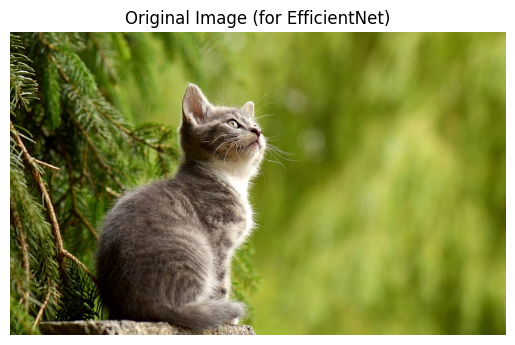

In [12]:
# 2. Get the specific transforms for this 'timm' model
# This is a robust way to get the correct preprocessing
config = model_effnet.default_cfg
effnet_transforms = timm.data.create_transform(
    input_size=config['input_size'],
    is_training=False,
    mean=config['mean'],
    std=config['std'],
    interpolation=config['interpolation']
)

print(f"EfficientNet transforms:\n{effnet_transforms}")

# 3. Load the same image as before
# We can re-use the 'img' variable from the ResNet example
plt.imshow(img)
plt.title("Original Image (for EfficientNet)")
plt.axis("off")
plt.show()

# 4. Preprocess the image
input_tensor = effnet_transforms(img)
input_batch = input_tensor.unsqueeze(0)
input_batch = input_batch.to(device)

### 4.2. Run Inference

In [13]:
# 5. Run inference
with torch.no_grad():
    output = model_effnet(input_batch)

# 6. Post-process
probabilities = F.softmax(output[0], dim=0)

# 7. Show top 5 predictions (we can re-use the 'categories' list)
top5_prob, top5_catid = torch.topk(probabilities, 5)

print("\n--- Top 5 Predictions (EfficientNet-B0) ---")
for i in range(top5_prob.size(0)):
    category_name = categories[top5_catid[i]].split(",")[0]
    print(f"  {i+1}. {category_name:<20} | Probability: {top5_prob[i].item():.4f}")


--- Top 5 Predictions (EfficientNet-B0) ---
  1. tiger cat            | Probability: 0.7224
  2. tabby                | Probability: 0.0806
  3. Egyptian cat         | Probability: 0.0566
  4. lynx                 | Probability: 0.0164
  5. Persian cat          | Probability: 0.0056


## 5. Comparison & Conclusion

| Model | Key Idea | What it Solved |
| :--- | :--- | :--- |
| **ResNet** | Skip Connections (F(x) + x) | **Vanishing Gradients**. Enabled extremely deep (100+ layer) networks without performance degradation. |
| **EfficientNet** | Compound Scaling (Balancing d, w, r) | **Efficiency**. Achieved SOTA accuracy with far less computation (FLOPS) and fewer parameters. |

---

### Key Takeaways:

* **ResNet** fundamentally changed how we build deep networks, making depth a commodity.
* **EfficientNet** changed how we think about scaling them, proving that a **balanced approach** is far more efficient.
* These CNN-based "**backbones**" are not just for classification! They are the foundation for more complex tasks like **Object Detection** and **Segmentation**.